# [Generator]
These codes are converts an image by using the learned weight.

In [1]:
import caffe
import os
import numpy as np
import SimpleITK as sitk

import matplotlib.pyplot as plt  

In [2]:
def windowing(data, level, width, out_min, out_max):
    return np.piecewise(data, 
                         [data <= (level - 0.5 - (width-1)/2),
                          data > (level - 0.5 + (width-1)/2)],
                        [out_min, out_max, lambda data: ((data - (level - 0.5))/(width-1) + 0.5)*(out_max-out_min)])

### 1. Load trained-weight

In [3]:
DEPLOY_DIR = os.getcwd() + "/weight/10to70/"
MEAN_FILE = DEPLOY_DIR + "train_image_mean_10to70.binaryproto"
MODEL_FILE = DEPLOY_DIR + "deploy.prototxt"
PRETRAINED = DEPLOY_DIR + "snapshot_iter_119400.caffemodel"

In [4]:
blob = caffe.proto.caffe_pb2.BlobProto()
data = open(MEAN_FILE, 'rb').read()
blob.ParseFromString(data)
mean = np.array(caffe.io.blobproto_to_array(blob))

In [5]:
net = caffe.Net(MODEL_FILE, PRETRAINED,caffe.TEST)
# caffe.set_mode_cpu()
caffe.set_mode_gpu()
caffe.set_device(0)

### 2. Load images

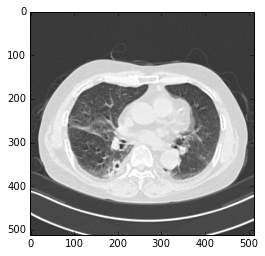

In [6]:
fn_in = os.getcwd() + "/data/noncontrast/test1_B10.mha"
image_in = sitk.ReadImage(fn_in)
nda_in = sitk.GetArrayFromImage(image_in)

plt.imshow(windowing(nda_in,-600,1500,0,255), vmin=0, vmax=255, cmap='gray')
plt.show()

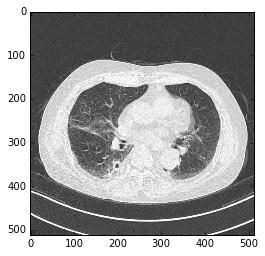

In [7]:
fn_gt = os.getcwd() + "/data/noncontrast/test1_B70.mha"
image_gt = sitk.ReadImage(fn_gt)
nda_gt = sitk.GetArrayFromImage(image_gt)

plt.imshow(windowing(nda_gt,-600,1500,0,255), vmin=0, vmax=255, cmap='gray')
plt.show()

### 3. Convert to different kernel

In [8]:
nda_in_ = np.float_(nda_in) - np.float_(mean[0,0,:])
out = net.forward_all(data=np.asarray([nda_in_]))
nda_out = out['conv6']

#nda_out = nda_in_ + nda_out[0,0,:] + np.float_(mean[0,0,:])
nda_out = nda_in + nda_out[0,0,:]
    
image_out = sitk.GetImageFromArray(nda_out)
image_out.SetDirection(image_in.GetDirection())
image_out.SetOrigin(image_in.GetOrigin())
image_out.SetSpacing(image_in.GetSpacing())

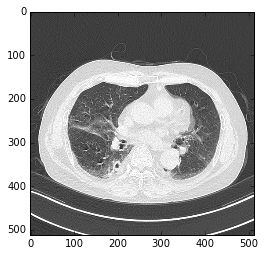

In [9]:
plt.imshow(windowing(nda_out,-600,1500,0,255), vmin=0, vmax=255, cmap='gray')
plt.show()

In [10]:
fn_out = os.getcwd() + "/data/noncontrast/test1_B70_fromB10.mha"
sitk.WriteImage(image_out, fn_out)

### Calculate RMSE

In [11]:
def GetRMSE(prediction, groundtruth):
    return np.sqrt(((prediction - groundtruth).astype('double') ** 2).mean())

In [12]:
rmse_ori = GetRMSE(nda_in, nda_gt) # original
rmse_convt = GetRMSE(nda_out, nda_gt) # converted
difference = 100*((rmse_convt-rmse_ori)/rmse_ori)

print(rmse_ori, rmse_convt, difference)

(106.08481024717649, 70.193172847438007, -33.832965639577758)


### Difference map
#### (Input - Target)

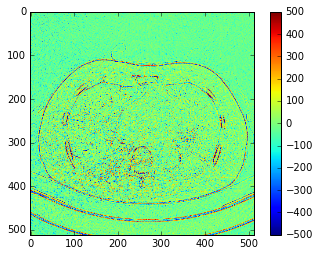

In [13]:
plt.imshow(nda_in-nda_gt, vmin=-500, vmax=500, cmap='jet');plt.colorbar();plt.show()

#### (Converted - Target)

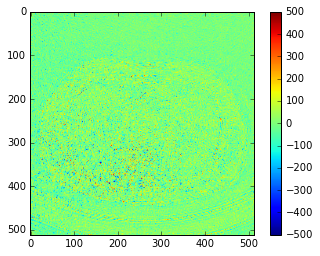

In [14]:
plt.imshow(nda_out-nda_gt, vmin=-500, vmax=500, cmap='jet');plt.colorbar();plt.show()